**Library**

In [1]:
# basic data analysis dan visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks', palette='Set2')
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

# statistic
from scipy.stats import normaltest,kruskal

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,RobustScaler
import category_encoders as ce

# model regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBClassifier

# model selection & hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV

# metric regression
from sklearn.metrics import r2_score

from datetime import date
import warnings
warnings.filterwarnings('ignore')

# Business Problem

Bagaimana cara untuk memprediksi kisaran harga jual mobil bekas sehingga harganya sesuai dengan harga jual yang ada pada pasaran?

* Value: harga mobil bekas.
* Goals: mendapatkan harga mobil bekas sehingga harganya sesuai dengan harga yang ada pada pasaran.
* Konteks project: suatu platform yang mampu memberikan kisaran harga mobil bekas berdasarkan data yang didapatkan dari dealer-dealer mobil bekas di UK, dengan target pengguna platformnya adalah masyarakat umum (end-user).

# Data Understanding

In [2]:
# mendapatkan current_date
todays_date = date.today()

# menggabungkan keseluruhan data menjadi satu dataframe
car_models = ['audi', 'bmw', 'cclass', 'focus', 'ford', 'hyundi', 'merc', 'skoda', 'toyota', 'vauxhall', 'vw']
df = pd.DataFrame()

for i in car_models:
    carmodel_df = pd.read_csv('dataset/'+i+'.csv')
    if i == 'hyundi':
        carmodel_df = carmodel_df.rename(columns={'tax(£)': 'tax'})

    carmodel_df['brand']=i   # feature engineering
    carmodel_df['age']=todays_date.year-carmodel_df['year']  # feature engineering
    df = pd.concat([df, carmodel_df])
    
# karena dataframe ini merupakan penggabungan dari banyak dataframe
# maka perlu dilakukan reset_index untuk menghilangkan index yang duplikat
df = df.reset_index()    

# drop index lama
df = df.drop(columns='index')

In [3]:
### remove whitespace on categorical data
df['model']=df['model'].str.strip()
df['transmission']=df['transmission'].str.strip()
df['fuelType']=df['fuelType'].str.strip()

In [4]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi,4
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi,5
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi,5
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi,4
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi,2


- `model` = tipe mobil.
- `year` = tahun pertama registrasi mobil.
- `price` = nilai harga mobil.
- `transmission` = tipe transmisi dari mobil.
- `mileage` = total jarak yang telah ditempuh oleh mobil.
- `fuelType` = jenis bahan bakar yang digunakan pada mobil.
- `tax` = nilai pajak mobil.
- `mpg` = miles per gallon; total jarak tempuh mobil berdasarkan total konsumsi bahan bakar yg digunakan. semakin besar nilai mpg berarti konsumsi bahan bakar yg digunakan akan semakin sedikit (semakin irit).
- `engineSize` = engine capacity atau engine displacement (kapasitas mesin); volume total silinder mesin. secara umum, semakin besar nilai kapasitas mesin akan meningkatkan kebutuhan konsumsi bahan bakar (kendaraan akan semakin boros).
- `brand` = merk mobil.
- `age` = umur mobil dari tahun pertama registrasi mobil hingga tahun saat ini.

* Data yang digunakan sebagai _Feature_ adalah `model`, `transmission`, `mileage`, `fuelType`, `tax`, `mpg`, `engineSize`, `brand`, dan `age`.
* Data yang digunakan sebagai _Label_ adalah `price`.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   tax           99187 non-null   float64
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
 9   brand         108540 non-null  object 
 10  age           108540 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 9.1+ MB


> Dari data di atas dapat diketahui bahwa total data `tax` & `mpg` berbeda dengan data lain, hal ini kemungkinan terjadi karena adanya missing value pada fitur tersebut.

In [6]:
df.describe()

,year,price,mileage,tax,mpg,engineSize,age
count,108540.000000,108540.000000,108540.000000,99187.000000,99187.000000,108540.000000,108540.000000
mean,2017.098028,16890.124046,23025.928469,120.299838,55.166825,1.661644,3.901972
std,2.130057,9756.266820,21176.423684,63.150926,16.138522,0.557058,2.130057
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000,-39.000000
25%,2016.000000,10229.500000,7491.750000,125.000000,47.100000,1.200000,2.000000
50%,2017.000000,14698.000000,17265.000000,145.000000,54.300000,1.600000,4.000000
75%,2019.000000,20940.000000,32236.000000,145.000000,62.800000,2.000000,5.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000,51.000000


Dari data di atas didapatkan info bahwa :  
* `year` memiliki nilai paling besar sebesar 2060, hal tersebut tidak mungkin karena `year` disini adalah tahun pertama registrasi mobil, sedangkan data ini dibuat pada tahun 2020.
* terdapat data dengan nilai minimum `tax` sebesar 0, hal ini kemungkinan terjadi karena terdapat data mobil dengan `fuelType electric`.
* `engineSize` memiliki nilai paling kecil sebesar 0, hal tersebut tidak mungkin karena tidak ada kendaraan dengan engineSize = 0.
* `age` memiliki nilai minimum -39 tahun, hal ini terjadi karena terdapat data mobil dengan `year` senilai 2060.

In [7]:
df.describe(include=object)

,model,transmission,fuelType,brand
count,108540,108540,108540,108540
unique,195,4,5,11
top,Focus,Manual,Petrol,ford
freq,10042,61308,59875,17965


Dari data di atas didapatkan info bahwa :
* Mobil dengan model terbanyak adalah `Mobil Focus`.
* Mobil dengan jenis transmisi `Manual` lebih banyak dibandingkankan jenis transmisi lainnya.
* Mobil dengan jenis bahan bakar `Petrol` lebih banyak dibandingkan dengan `Diesel`.
* Brand mobil terbanyak adalah `brand Ford`.

# EDA

## Data Distribution Plot

In [8]:
kolom=df.columns

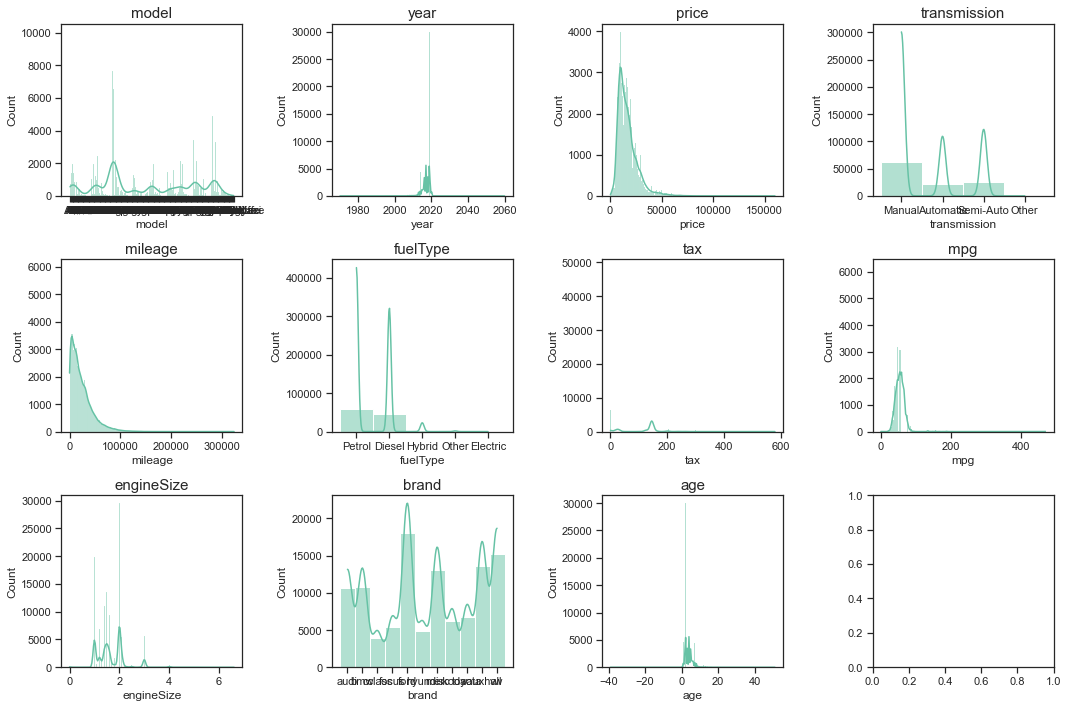

In [9]:
figure, axis = plt.subplots(3,4,figsize=(15,10))

k=0

for i in range(0,3):
    for j in range (0,4):
        if(k == 11):
            break;
        axis[i,j].set_title(kolom[k], size=15)
        sns.histplot(ax=axis[i,j], data = df, x=kolom[k], kde=True)
        k+=1

# auto padding subplot
plt.tight_layout()
plt.show()

* Berdasarkan histplot, sebaran data pada tiap feature cenderung *right-skew*
* Dapat disimpulkan secara umum persebaran data memiliki distribusi tidak normal.

In [11]:
num_features=list(df.dtypes[df.dtypes!=object].index)
num_features.remove('year')
num_features

['price', 'mileage', 'tax', 'mpg', 'engineSize', 'age']

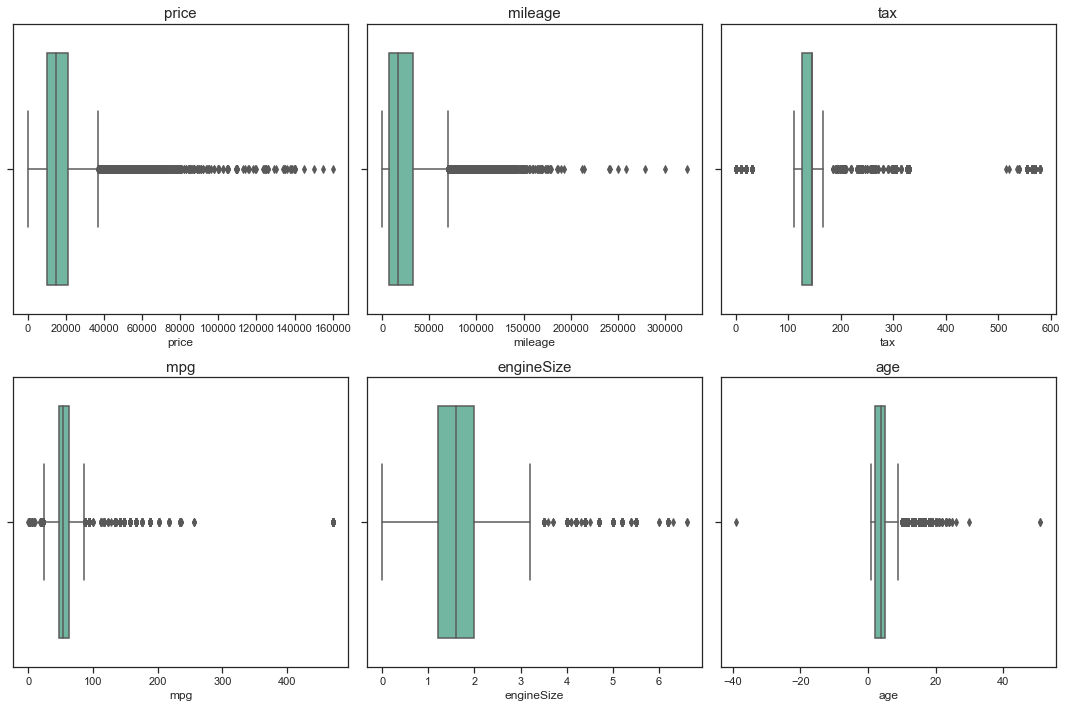

In [12]:
figure, axis = plt.subplots(2,3,figsize=(15,10))

k=0

for i in range(0,2):
    for j in range (0,3):
        axis[i,j].set_title(num_features[k], size=15)
        sns.boxplot(ax=axis[i,j], data = df, x=num_features[k])
        k+=1

# auto padding subplot
plt.tight_layout()
plt.show()

* Berdasarkan boxplot, sebaran data pada tiap feature memiliki banyak outlier di sebelah kanan.
* Dapat disimpulkan persebaran data memiliki distribusi tidak normal.

## Data Correlation

In [13]:
factors = df[num_features]

In [14]:
for i in factors:
    stats,pval=normaltest(factors[i])
    print('Nilai p-Value =',pval)
    if pval <= 0.05:
        print(f'Fitur {i} distribusi tidak normal\n')
    else:
        print(f'Fitur {i} distribusi normal\n')

Nilai p-Value = 0.0
Fitur price distribusi tidak normal

Nilai p-Value = 0.0
Fitur mileage distribusi tidak normal

Nilai p-Value = nan
Fitur tax distribusi normal

Nilai p-Value = nan
Fitur mpg distribusi normal

Nilai p-Value = 0.0
Fitur engineSize distribusi tidak normal

Nilai p-Value = 0.0
Fitur age distribusi tidak normal



* Setelah dilakukan pengecekan normalisasi data, didapatkan bahwa distribusi pada fitur `price`, `mileage`, `engineSize`, dan `age` terdistribusi tidak normal. Sedangkan pada fitur `tax` dan `mpg` nilai p-Valuenya NaN karena terdapat data NaN.
* Berdasarkan hal ini maka pengecekan uji korelasi akan dilakukan dengan menggunakan metode _Spearman_.

In [15]:
corr_matrix=df[num_features].corr(method='spearman')
corr_matrix

,price,mileage,tax,mpg,engineSize,age
price,1.000000,-0.523746,0.317650,-0.393450,0.573606,-0.606435
mileage,-0.523746,1.000000,-0.263119,0.336604,0.102945,0.813931
tax,0.317650,-0.263119,1.000000,-0.576143,0.165301,-0.329870
mpg,-0.393450,0.336604,-0.576143,1.000000,-0.206707,0.327676
engineSize,0.573606,0.102945,0.165301,-0.206707,1.000000,0.040957
age,-0.606435,0.813931,-0.329870,0.327676,0.040957,1.000000


Keterangan:
* 0-0.3 = weak correlation
* 0.3-0.7 = moderate correlation
* 0.7-1 = strong correlation

* Positive (+) = one variable increases as the other increases the correlation
* Negative (-) = when one decreases as the other increases it
* Complete absence of correlation is represented by 0

_Referensi: materi Association_

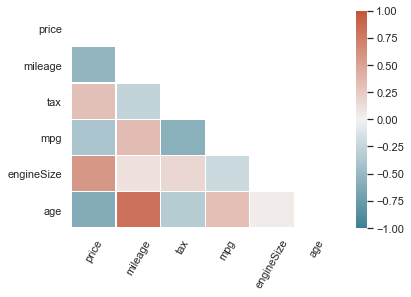

In [16]:
# plt.figure(figsize=(12,8))

sns.set_theme(style='white')

mask=np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap=sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(corr_matrix,
            mask=mask,
            cmap=cmap,
            vmax=1,
            vmin=-1,
            linewidths=.2
           )

plt.yticks(rotation=0)
plt.xticks(rotation=60)
plt.show()

Setelah dilakukan perhitungan uji korelasi menggunakan metode _Spearman_, didapatkan hasil bahwa setiap _numerical feature_ memiliki korelasi **moderate** terhadap fitur `price`, dimana fitur `age` menjadi fitur yang memiliki nilai korelasi yang paling tinggi dibanding fitur-fitur numerikal lainnya dengan nilai korelasi sebesar **0.606435** dengan arah negatif. Hal ini dapat diartikan bahwa `semakin tua mobil` maka `harga mobil` tersebut akan `semakin rendah`.

## Data Cardinalities

### Brand

In [17]:
df['brand'].nunique()

11

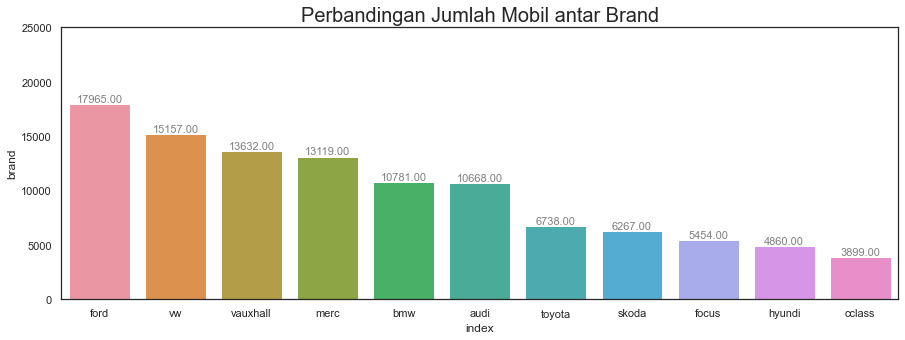

In [18]:
df_brand=pd.DataFrame(df['brand'].value_counts()).reset_index()

plt.figure(figsize=(15,5))

brand=sns.barplot(data=df_brand, x='index', y='brand', ci=None)
for p in brand.patches:
    height = p.get_height()
    brand.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
                textcoords='offset points')
plt.ylim(0, 25000)    
plt.title('Perbandingan Jumlah Mobil antar Brand', size=20) 
plt.show()

>Berdasarkan data di atas didapatkan info bahwa brand mobil yang paling banyak digunakan di UK adalah mobil dari brand `Ford` dan brand mobil yang paling sedikit digunakan di UK adalah mobil dari brand `CClass`.

### Model

In [19]:
df['model'].nunique()

195

In [20]:
df['model'].value_counts()

Focus              10042
C Class             7646
Fiesta              6557
Golf                4863
Corsa               3441
                   ...  
180                    1
Amica                  1
Transit Tourneo        1
200                    1
RS7                    1
Name: model, Length: 195, dtype: int64

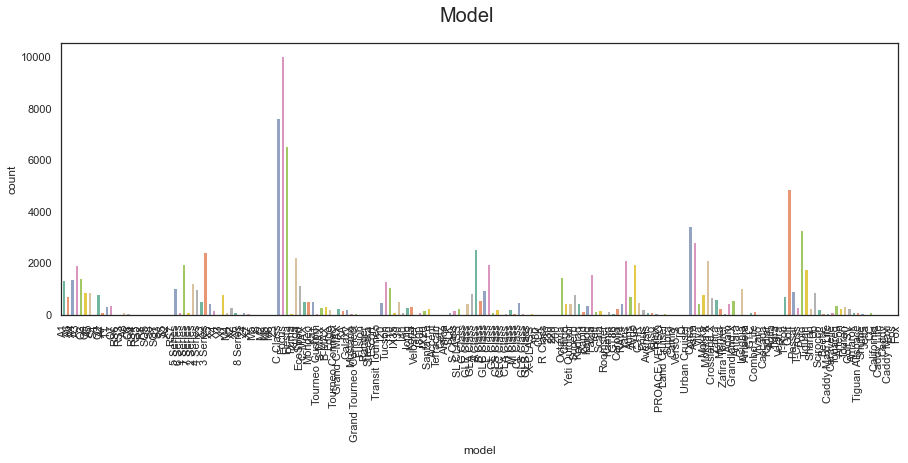

In [21]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='model', palette='Set2')
plt.xticks(rotation=90)
plt.suptitle('Model', size=20)
plt.show()

>Berdasarkan data di atas didapatkan info bahwa mobil yang paling banyak digunakan di UK adalah mobil dengan model `Focus`.

### Transmission

In [22]:
df['transmission'].nunique()

4

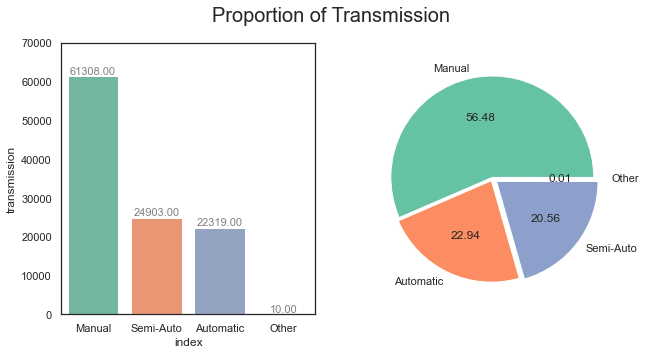

In [23]:
df_transm=pd.DataFrame(df['transmission'].value_counts()).reset_index()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
transm=sns.barplot(data=df_transm, x='index', y='transmission', ci=None, palette='Set2')
for p in transm.patches:
    height = p.get_height()
    transm.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
                textcoords='offset points')
plt.ylim(0, 70000)  

plt.subplot(1,2,2)
plt.pie(df['transmission'].value_counts(), labels=(df['transmission']).unique(), autopct='%.2f', colors=['#66c2a5','#fc8d62','#8da0cb','#e78ac3'], explode = (0.01, 0.025, 0.05, 0.07))

plt.suptitle('Proportion of Transmission', size=20)
plt.show()

Berdasarkan data di atas, didapatkan info sebagai berikut:
* Mobil dengan transmisi `Manual` merupakan mobil dengan jumlah terbanyak dengan jumlah 56.48% dari keseluruhan data.
* Mobil dengan transmisi `Semi-Auto` merupakan mobil dengan jumlah terbanyak kedua dengan jumlah 22.94% dari keseluruhan data.
* Mobil dengan transmisi `Automatic` merupakan mobil dengan jumlah terbanyak ketiga dengan jumlah 20.56% dari keseluruhan data.
* Mobil dengan transmisi `Other` merupakan mobil dengan jumlah paling sedikit dengan jumlah hanya 0.01% dari keseluruhan data.

Dapat dikatakan bahwa penduduk UK mayoritas menggunakan mobil dengan `transmisi Manual`.

### FuelType

In [24]:
df['fuelType'].nunique()

5

In [25]:
df['fuelType'].value_counts()

Petrol      59875
Diesel      45177
Hybrid       3229
Other         253
Electric        6
Name: fuelType, dtype: int64

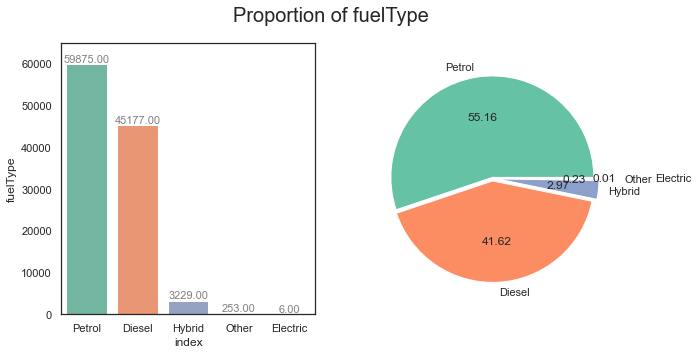

In [26]:
df_fuel=pd.DataFrame(df['fuelType'].value_counts()).reset_index()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
fuel=sns.barplot(data=df_fuel, x='index', y='fuelType', ci=None, palette='Set2')
for p in fuel.patches:
    height = p.get_height()
    fuel.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
                textcoords='offset points')
plt.ylim(0, 65000)

plt.subplot(1,2,2)
plt.pie(df['fuelType'].value_counts(), labels=(df['fuelType']).unique(), autopct='%.2f', colors=['#66c2a5','#fc8d62','#8da0cb','#e78ac3', '#a6d854'], explode = (0.01, 0.025, 0.05, 0.2, 0.5))

plt.suptitle('Proportion of fuelType', size=20)
plt.show()

Berdasarkan data di atas, didapatkan info sebagai berikut:
* Mobil dengan jenis bahan bakar `Petrol` merupakan mobil dengan jumlah terbanyak dengan jumlah 55.16% dari keseluruhan data.
* Mobil dengan jenis bahan bakar `Diesel` merupakan mobil dengan jumlah terbanyak kedua dengan jumlah 41.62% dari keseluruhan data.
* Mobil dengan jenis bahan bakar `Hybrid` merupakan mobil dengan jumlah terbanyak ketiga dengan jumlah 2.97% dari keseluruhan data.
* Mobil dengan jenis bahan bakar `Other` merupakan mobil dengan jumlah terbanyak keempat dengan jumlah 0.23% dari keseluruhan data.
* Mobil dengan jenis bahan bakar `Electric` merupakan mobil dengan jumlah paling sedikit dengan jumlah 0.01% dari keseluruhan data.

Dapat dikatakan bahwa penduduk UK mayoritas menggunakan mobil dengan jenis `bahan bakar Petrol`.

## General Data Visualization

### Car Based on Year and FuelType

In [27]:
yearXfuel = pd.crosstab(df['year'], df['fuelType']).reset_index()

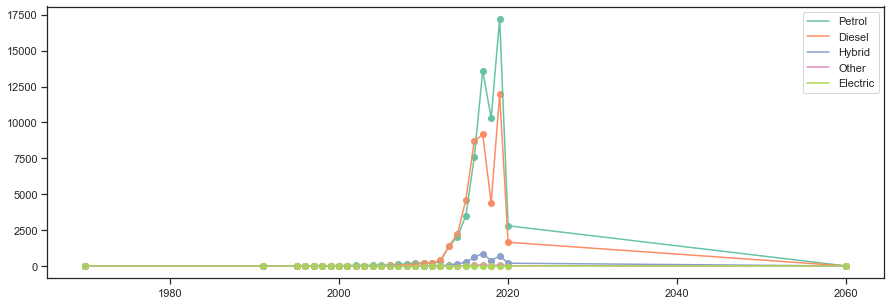

In [28]:
sns.set_theme(style='ticks', palette='Set2')
plt.figure(figsize=(15,5))

plt.scatter(yearXfuel['year'], yearXfuel['Petrol'])
plt.plot(yearXfuel['year'], yearXfuel['Petrol'])

plt.scatter(yearXfuel['year'], yearXfuel['Diesel'])
plt.plot(yearXfuel['year'], yearXfuel['Diesel'])

plt.scatter(yearXfuel['year'], yearXfuel['Hybrid'])
plt.plot(yearXfuel['year'], yearXfuel['Hybrid'])

plt.scatter(yearXfuel['year'], yearXfuel['Other'])
plt.plot(yearXfuel['year'], yearXfuel['Other'])

plt.scatter(yearXfuel['year'], yearXfuel['Electric'])
plt.plot(yearXfuel['year'], yearXfuel['Electric'])

plt.legend(labels=['Petrol', 'Diesel', 'Hybrid', 'Other', 'Electric'])
plt.show()

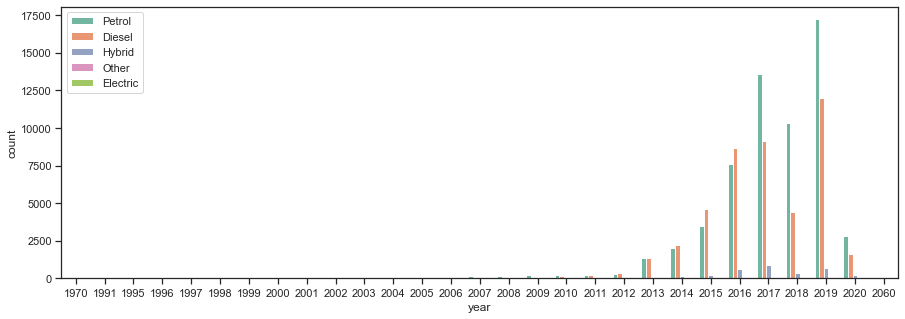

In [29]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='year', hue='fuelType', palette='Set2')
plt.legend(loc='upper left')
plt.show()

Berdasarkan dara di atas, didapatkan info sebagai berikut:
* Mobil dengan jumlah data paling banyak adalah mobil dengan tahun registrasi 2019.
* Mobil dengan jumlah data paling sedikit adalah mobil dengan tahun registrasi 2020, serta terdapat perbedaan jumlah mobil yang signifikan antara mobil dengan tahun registrasi 2020 dengan data mobil-mobil pada 5 tahun sebelumnya. Hal ini kemungkinan dapat disebabkan oleh pada saat data ini dibuat (pada tahun 2020) mobil dengan tahun registrasi 2020 masih aktif digunakan dan belum dijual kembali oleh penggunanya karena mobil-mobil tersebut masih tergolong sebagai kendaraan baru. 
* Secara umum, mobil dengan bahan bakar Petrol merupakan mobil dengan jumlah data paling banyak.
* Mobil dengan tahun registrasi 2060 merupakan data anomali.

### Year vs Tax vs Fuel

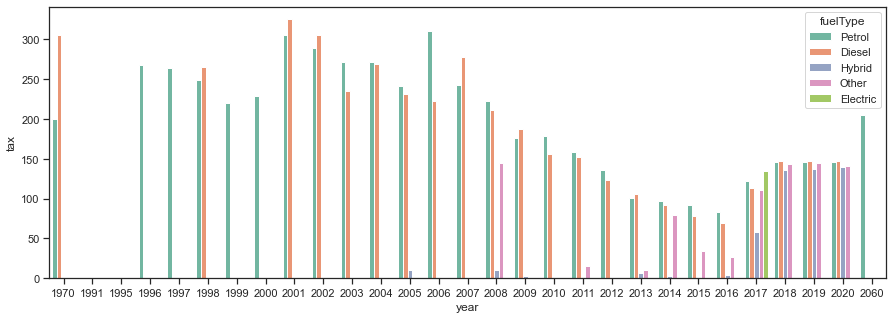

In [30]:
plt.figure(figsize=(15,5))
sns.barplot(data=df, x='year', y='tax', hue='fuelType', ci=None, palette='Set2')
plt.show()

* Rata-rata nilai pajak mobil yang paling rendah terdapat pada mobil dengan tahun registrasi 2016.
* Rata-rata nilai pajak mobil yang paling tinggi terdapat pada mobil dengan tahun registrasi 2001.
* Secara umum, semakin baru tahun registrasi mobil maka rata-rata nilai pajak mobil bekas di UK akan semakin rendah.
* Dilansir dari https://www.gov.uk/government/news/new-vehicle-tax-rates-from-1-april-2017, (2017) per tanggal 1 April 2017 telah diberlakukan standarisasi nilai pajak di UK dimana mobil-mobil ditiap jenis _fuelType_ akan memiliki kisaran nilai pajak yang saling tidak jauh berbeda. Hal ini dapat menjadi alasan yang menyebabkan rata-rata nilai pajak mobil mulai tahun registrasi 2017 hingga mobil tahun registrasi 2020 memiliki grafik rata-rata nilai pajak yang mendatar.
* Mobil dengan tahun registrasi 2060 merupakan data anomali.

### Brand vs Price Trend

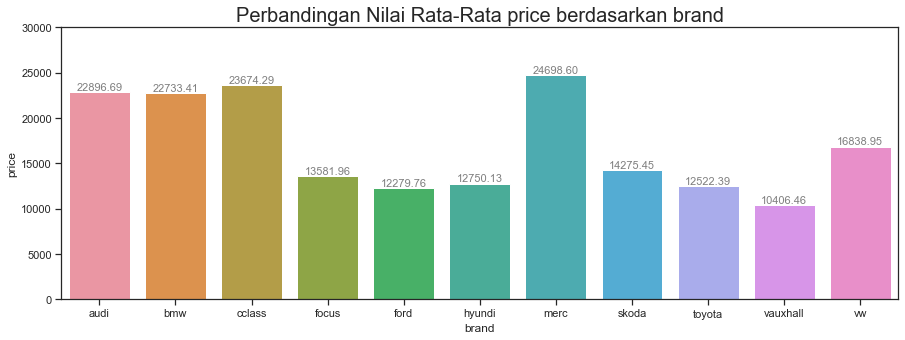

In [74]:
df_bXp=pd.DataFrame(df.groupby('brand')['price'].mean()).reset_index()

plt.figure(figsize=(15,5))

brandXprice=sns.barplot(data=df_bXp, x='brand', y='price', ci=None)
for p in brandXprice.patches:
    height = p.get_height()
    brandXprice.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
                textcoords='offset points')
plt.ylim(0, 30000)    
plt.title('Perbandingan Nilai Rata-Rata price berdasarkan brand', size=20) 
plt.show()

* Berdasarkan grafik diatas terdapat 4 brand yang memiliki rata-rata harga lebih tinggi dibanding brand lainnya, yaitu audi, bmw, merc, cclass dimana keempat brand tersebut memang termasuk brand mobil mewah.

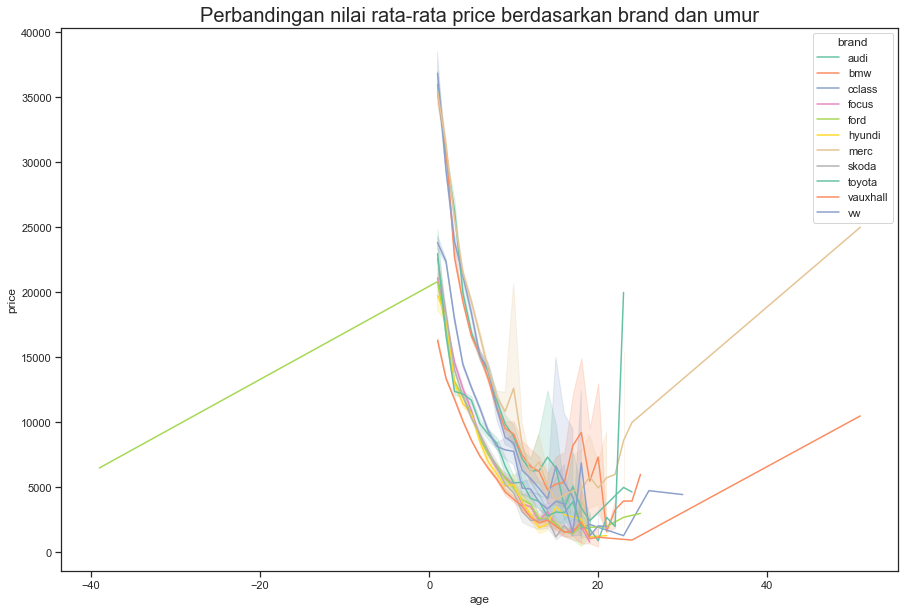

In [72]:
plt.figure(figsize=(15,10))
plt.title('Perbandingan nilai rata-rata price berdasarkan brand dan umur', size=20)
sns.lineplot(data=df, x='age', y='price', hue='brand', palette='Set2')
plt.show()

* Berdasarkan grafik di atas dapat terlihat adanya tren penurunan harga mobil ketika umur mobil cenderung semakin tua dihampir semua jenis brand mobil.
* Terlihat anomali peningkatan harga yang signifikan untuk brand toyota berumur diatas 20 tahun.
* Terlihat tren peningkatan harga untuk mobil dengan brand vauxhall & merc yang berumur diatas 30 tahun.
* Mobil dengan umur -39 tahun adalah data anomali.

In [34]:
# pola data yang unik pada brand toyota
df[(df['brand'] == 'toyota') & (df['age'] >= 20)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
73302,Corolla,2001,899,Automatic,76000,Petrol,300.0,35.3,1.6,toyota,20
75463,Yaris,1999,1995,Automatic,89000,Petrol,160.0,42.9,1.3,toyota,22
75621,Yaris,2000,2695,Automatic,21000,Petrol,160.0,42.9,1.3,toyota,21
79707,Land Cruiser,1998,19990,Manual,100000,Diesel,265.0,23.9,4.2,toyota,23


> Berdasarkan tabel di atas, dapat kita ketahui bahwa anomali pada tren harga toyota dikarenakan adanya data "Land Cruiser" tahun 1998 yang memiliki harga £19990, sedangkan harga-harga mobil brand Toyota lainnya relatif jauh lebih rendah dibanding nilai price dari data "Land Cruiser".

In [75]:
df[((df['brand'] == 'vauxhall') | (df['brand'] == 'merc')) & (df['age'] >= 30)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
65699,M Class,1970,24999,Automatic,14000,Diesel,305.0,39.2,0.0,merc,51
90588,Zafira,1970,10495,Manual,37357,Petrol,200.0,42.2,1.4,vauxhall,51


* Berdasarkan tabel di atas, dapat kita ketahui tren peningkatan harga pada mobil dengan brand Vauxhall disebabkan oleh 1 data yaitu mobil model "Zahira" keluaran tahun 1970 yang memiliki harga £10495.
* Berdasarkan tabel di atas, dapat kita ketahui tren peningkatan harga pada mobil dengan brand Merc disebabkan oleh 1 data yaitu mobil model "M Class" keluaran tahun 1970 yang memiliki harga £24999.

### Tree Map

In [79]:
df_treemap = df.groupby(['year','transmission','fuelType']).agg({'model':len,'price':np.mean}).rename(columns={'name':'total'}).reset_index()

fig = px.treemap(df_treemap,
                 path=['year','transmission','fuelType'], 
                 values = 'price', 
                 color = 'price',
                 color_continuous_scale='RdBu',
                 color_continuous_midpoint=np.average(df['price'], weights=df['price']),
                 width=1000,
                 height=600,
                 title = "Nilai Rata-Rata price berdasarkan year, transmission, dan fuelType:"
                 )
fig.show()

## Identifying Missing Values, Anomaly Data & Duplicated Data

### Missing Value

In [38]:
df.isna().sum() / df.shape[0] * 100

model           0.0000
year            0.0000
price           0.0000
transmission    0.0000
mileage         0.0000
fuelType        0.0000
tax             8.6171
mpg             8.6171
engineSize      0.0000
brand           0.0000
age             0.0000
dtype: float64

> Sesuai dengan analisis sebelumnya, terdapat missing value pada fitur tax & mpg sebesar 8.62% dari keseluruhan data.

### Anomaly Data

**Data 'year' = 2060**

In [39]:
df[df['year'] == 2060]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
48528,Fiesta,2060,6495,Automatic,54807,Petrol,205.0,42.8,1.4,ford,-39


Data `year` = 2060 merupakan hal yang tidak mungkin, karena fitur `year` adalah `tahun registrasi pertama kendaraan` sedangkan data yang digunakan saat ini adalah data per tahun 2020.

### Duplicated Data

In [40]:
df[df.duplicated(keep='first')==True]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
273,Q3,2019,34485,Automatic,10,Diesel,145.0,47.1,2.0,audi,2
764,Q2,2019,22495,Manual,1000,Diesel,145.0,49.6,1.6,audi,2
784,Q3,2015,13995,Manual,35446,Diesel,145.0,54.3,2.0,audi,6
967,Q5,2019,31998,Semi-Auto,100,Petrol,145.0,33.2,2.0,audi,2
990,Q2,2019,22495,Manual,1000,Diesel,145.0,49.6,1.6,audi,2
...,...,...,...,...,...,...,...,...,...,...,...
107860,Golf SV,2019,19360,Semi-Auto,4401,Diesel,145.0,50.4,2.0,vw,2
107878,Golf SV,2019,22798,Manual,10,Petrol,145.0,43.5,1.5,vw,2
107881,Golf SV,2019,23998,Semi-Auto,10,Diesel,145.0,50.4,2.0,vw,2
107882,Golf SV,2019,21998,Semi-Auto,10,Petrol,145.0,42.8,1.5,vw,2


Berdasarkan data di atas, didapatkan info bahwa terdapat 2273 data yg terindikasi _Duplicated Data_.

## Uji Analisa

### Uji 1 : _price_ vs _mileage_

**Korelasi :**

In [41]:
round(df['price'].corr(df['mileage'],method='spearman'),6)

-0.523746

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **moderate** serta **berbanding terbalik** dengan fitur _mileage_, dimana nilai korelasinya adalah 0.523746 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _mileage_** dari mobil akan menyebabkan **nilai _price_ semakin rendah**.

**Visualisasi :**

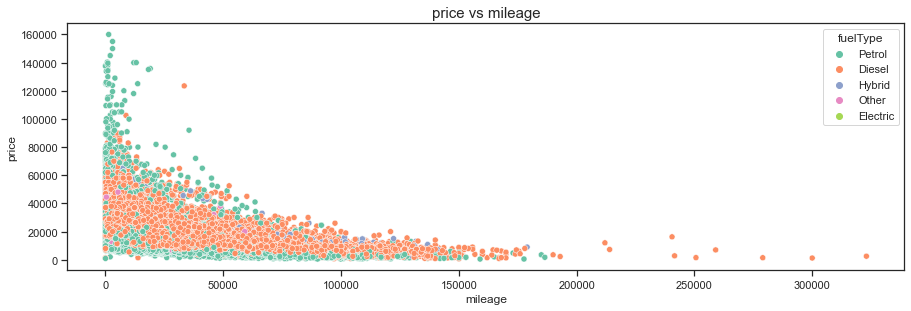

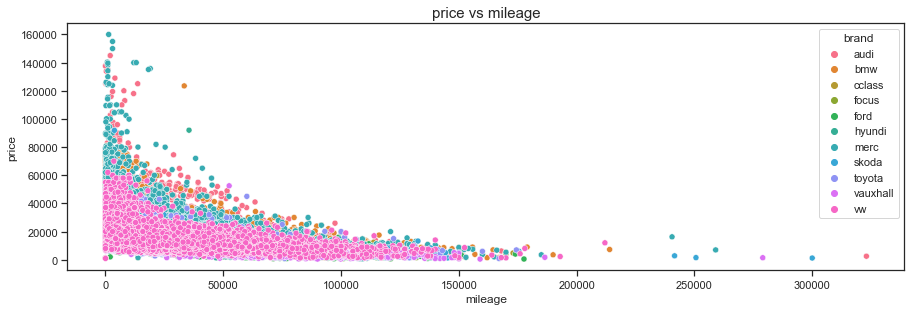

In [42]:
sns.set_theme(style='ticks', palette='Set2')
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.scatterplot(data=df, x='mileage', y='price', hue='fuelType')
plt.title('price vs mileage', size=15)
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.scatterplot(data=df, x='mileage', y='price', hue='brand')
plt.title('price vs mileage', size=15)
plt.show()

**Kesimpulan Uji 1 :**

1. Total jarak yg telah ditempuh memiliki pengaruh terhadap penentuan harga jual mobil, dimana semakin tinggi total jarak tempuh yg telah dilakukan mobil maka nilai jual mobil akan semakin rendah.
2. Pada data ini, secara umum digambarkan bahwa:
    * mobil yg memiliki harga jual tinggi adalah mobil dengan nilai jarak tempuh yg rendah dengan tipe bahan bakar bakar Petrol.
    * mobil yg memiliki harga jual rendah adalah mobil dengan jarak tempuh yg tinggi dengan tipe bahan bakar Diesel.

### Uji 2 : _price_ vs _tax_

**Korelasi :**

In [43]:
round(df['price'].corr(df['tax'],method='spearman'),6)

0.31765

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **moderate** serta **berbanding Lurus** dengan fitur _tax_, dimana nilai korelasinya adalah 0.31765 dengan arah positif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _tax_** dari mobil akan menyebabkan **nilai _price_ semakin tinggi**.

**Visualisasi :**

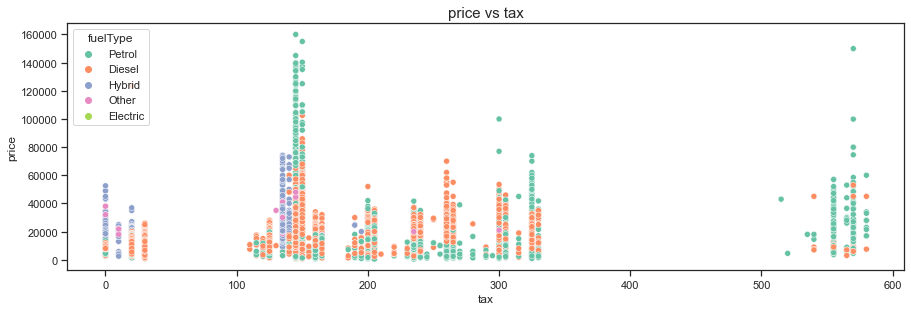

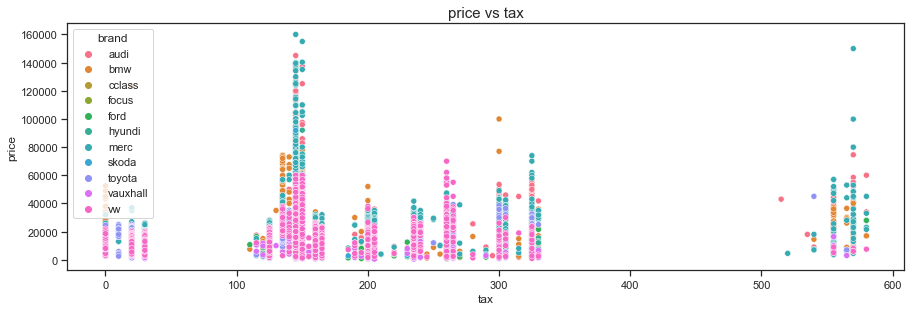

In [44]:
sns.set_theme(style='ticks', palette='Set2')
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.scatterplot(data=df, x='tax', y='price', hue='fuelType')
plt.title('price vs tax', size=15)
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.scatterplot(data=df, x='tax', y='price', hue='brand')
plt.title('price vs tax', size=15)
plt.show()

**Kesimpulan Uji 2 :**

1. Nilai pajak mobil memiliki pengaruh kecil terhadap penentuan harga mobil.
2. Pada data ini, secara umum digambarkan bahwa:
    * Mobil dengan jenis bahan bakar _Hybrid_ secara umum memiliki rata-rata range nilai _tax_ serta nilai _price_ yg relatif lebih rendah dibandingkan mobil dengan jenis bahan bakar lainnya. 
    * Terdapat mobil dengan jenis bahan bakar _Petrol_ yang memiliki nilai _price_ yang relatif rendah tapi memiliki nilai pajak yang lebih tinggi dibandingkan mobil dengan jenis bahan bakar lainnya, hal ini kemungkinan dipengaruhi oleh nama _brand_ dari jenis mobil tersebut.

### Uji 3 : _price_ vs _mpg_

**Korelasi :**

In [45]:
round(df['price'].corr(df['mpg'],method='spearman'),6)

-0.39345

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **moderate** serta **berbanding terbalik** dengan fitur _mpg_, dimana nilai korelasinya adalah 0.39345 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _mpg_** dari mobil akan menyebabkan **nilai _price_ semakin rendah**.

**Visualisasi :**

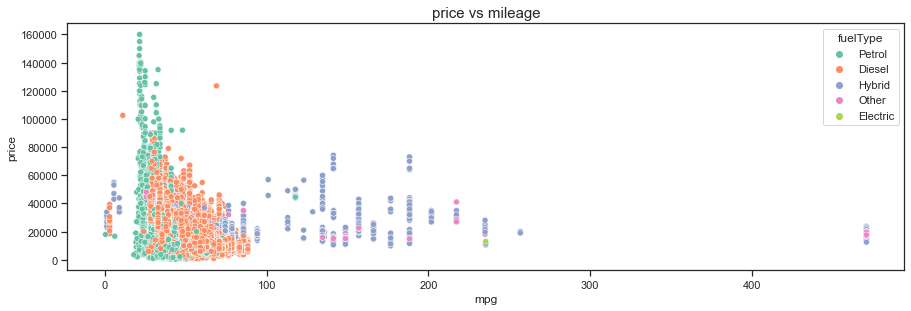

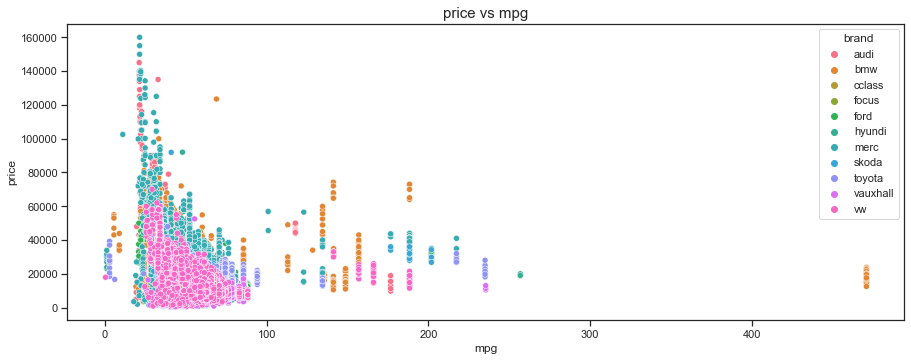

In [46]:
sns.set_theme(style='ticks', palette='Set2')
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.scatterplot(data=df, x='mpg', y='price', hue='fuelType')
plt.title('price vs mileage', size=15)
plt.show()

plt.figure(figsize=(15,12))
plt.subplot(2,1,2)
sns.scatterplot(data=df, x='mpg', y='price', hue='brand')
plt.title('price vs mpg', size=15)
plt.show()

**Kesimpulan Uji 3 :**

1. Total jarak tempuh mobil berdasarkan total konsumsi bahan bakar (mpg) yg digunakan memiliki pengaruh moderate terhadap penentuan harga jual mobil.
2. Pada data ini, secara umum digambarkan bahwa:
    * mobil dengan jenis bahan bakar bakar _Hybrid_ memiliki rata-rata nilai _mpg_ yang lebih tinggi serta kisaran _price_ yang relatif moderate jika dibandingkan mobil dengan dengan jenis bahan bakar bakar lainnya.
    * mobil dengan tipe bahan bakar bakar Petrol memiliki sebaran nilai _mpg_ yg relatif lebih rendah tetapi memiliki range harga jual yg paling variatif jika dibandingkan mobil dengan dengan jenis bahan bakar bakar lainnya. Hal ini dapat disebabkan karena terdapat mobil dengan _brand_ mewah dengan dengan jenis bahan bakar bakar _Petrol_ dimana mobil ini memiliki _price_ yang relatif tinggi dibanding mobil dari _brand_ lainnya.
    * mobil dengan tipe bahan bakar bakar Diesel memiliki sebaran nilai _mpg_ serta _price_ moderate.

### Uji 4 : _price_ vs _engineSize_

**Korelasi :**

In [47]:
round(df['price'].corr(df['engineSize'],method='spearman'),6)

0.573606

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **moderate** serta **berbanding Lurus** dengan fitur _engineSize_, dimana nilai korelasinya adalah 0.573606 dengan arah positif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _engineSize_** dari mobil akan menyebabkan **nilai _price_ semakin tinggi**.

**Visualisasi :**

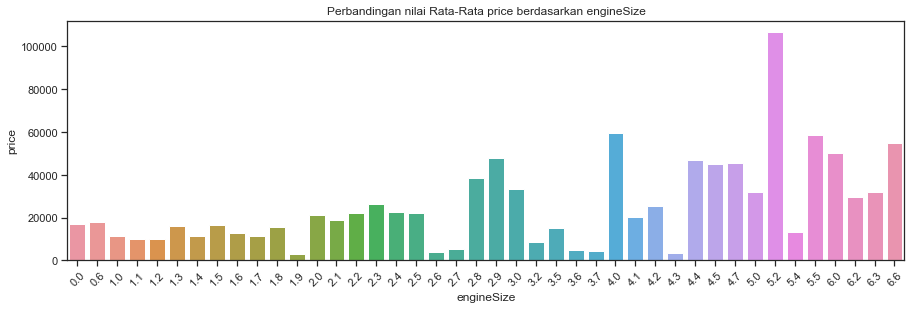

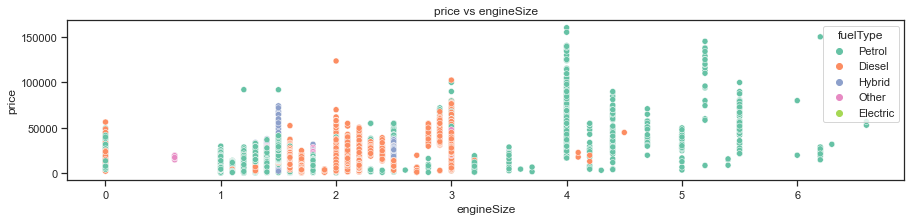

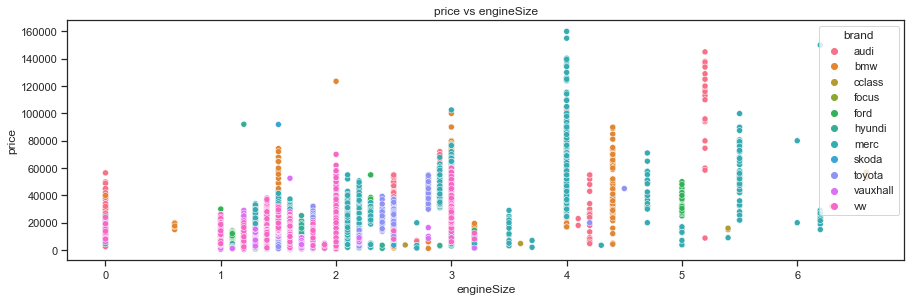

In [48]:
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
graph=sns.barplot(data=df, x='engineSize', y='price', ci=None)
plt.title('Perbandingan nilai Rata-Rata price berdasarkan engineSize')
plt.xticks(rotation=45)
plt.show()

sns.set_theme(style='ticks', palette='Set2')
plt.figure(figsize=(15,10))
plt.subplot(3,1,2)
sns.scatterplot(data=df, x='engineSize', y='price', hue='fuelType')
plt.title('price vs engineSize') 
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(3,1,3)
sns.scatterplot(data=df, x='engineSize', y='price', hue='brand')
plt.title('price vs engineSize') 
plt.show()

.**Kesimpulan Uji 4 :**

1. Nilai kapasitas mesin memiliki pengaruh terhadap penentuan harga jual mobil, dimana semakin besar nilai kapasitas mesin maka nilai jual mobil akan semakin tinggi.
2. Pada data ini, secara umum digambarkan bahwa:
    * mobil dengan _engineSize_ yang besar lebih banyak terdapat pada mobil dengan _fuelType Petrol_.
    * mobil dengan _fuelType Diesel_ memiliki sebaran nilai _engineSize_ yg relatif moderate dengan range _price_ yg relatif moderate.

### Uji 5 : _price_ vs _age_

Hipotesis:

Ho: rata-rata harga mobil di tiap umur bernilai sama

Ha: rata-rata harga mobil di tiap umur setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [49]:
ages=list(df['age'].unique())

In [50]:
stats,pval = kruskal(*[df[df['age'] == i]['price'] for i in ages])

print('Nilai statistic:',stats)
print('Nilai p-value:',pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata harga mobil di tiap umur setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata harga mobil di tiap umur bernilai sama.')

Nilai statistic: 42203.44910307679
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata harga mobil di tiap umur setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Korelasi :**

In [51]:
round(df['price'].corr(df['age'],method='spearman'),6)

-0.606435

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **moderate** serta **berbanding Terbalik** dengan fitur _age_, dimana nilai korelasinya adalah 0.606435 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _age_** dari mobil akan menyebabkan **nilai _price_ semakin rendah**.

**Visualisasi :**

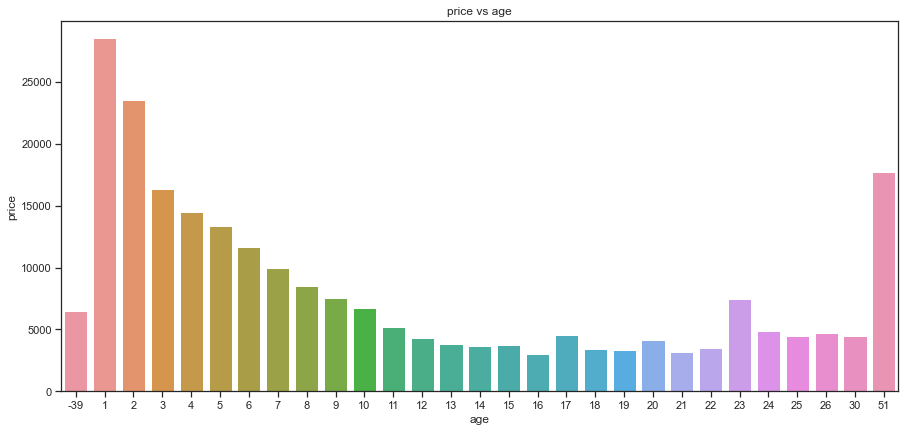

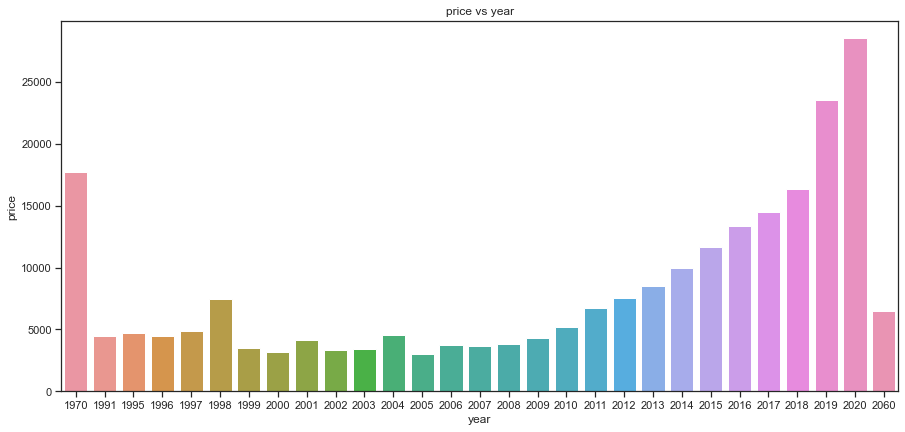

In [52]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
sns.barplot(data=df, x='age', y='price', ci=None)
plt.title('price vs age')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(2,1,2)
sns.barplot(data=df, x='year', y='price', ci=None)
plt.title('price vs year')
plt.show()

In [72]:
df[df['year']==1970]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
65699,M Class,1970,24999,Automatic,14000,Diesel,305.0,39.2,0.0,merc,51
90588,Zafira,1970,10495,Manual,37357,Petrol,200.0,42.2,1.4,vauxhall,51


**Kesimpulan Uji 5 :**

1. Umur mobil memiliki pengaruh besar terhadap penentuan harga jual mobil, dimana semakin muda umur mobil maka semakin mahal harga mobilnya.
2. Pada data ini, secara umum digambarkan bahwa terdapat tren penurunan harga mobil ketika umur mobil cenderung semakin tua atau dengan kata lain terdapat tren peningkatan harga mobil ketika tahun registrasi mobil yang semakin baru.
    * mobil dengan umur 1 tahun  memiliki rata-rata harga paling tinggi dibanding mobil dengan umur lainnya.
    * mobil dengan umur 51 tahun (tahun registrasi 1970) memiliki harga yg relatif cukup tinggi jika dibandingkan dengan mobil berumur lainnya. Hal ini kemungkinan dikarenakan mobil tersebut merupakan mobil dari brand Merc dan Vauxhall dengan model yang termasuk mobil antik / mobil klasik, sehingga memiliki nilai historis sebagai variabel perhitungan lainnya.
    * mobil dengan umur -39 tahun adalah mobil tahun registrasi 2060 yang merupakan data anomali.

### Uji 6 : _price_ vs _transmission_ 

Hipotesis:

Ho: rata-rata harga mobil tiap tipe transmisi saling bernilai sama 

Ha: rata-rata harga mobil tiap tipe transmisi setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [53]:
transm=list(df['transmission'].unique())

In [54]:
stats,pval = kruskal(*[df[df['transmission'] == i]['price'] for i in transm])

print('Nilai statistic:', stats)
print('Nilai p-value:', pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata harga mobil tiap tipe transmisi setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata harga mobil tiap tipe transmisi saling bernilai sama.')

Nilai statistic: 39714.51274729922
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata harga mobil tiap tipe transmisi setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Visualisasi :**

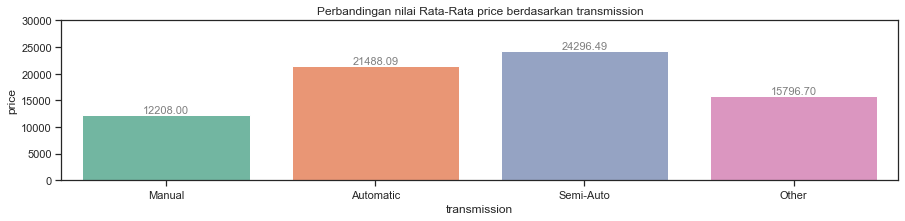

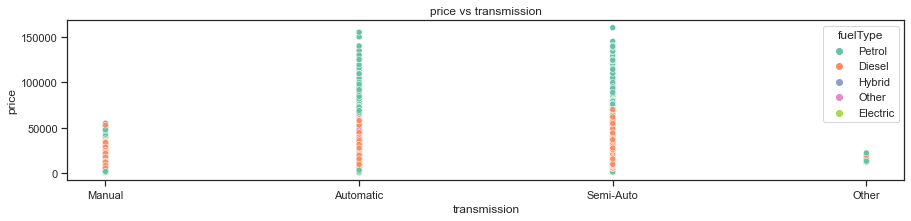

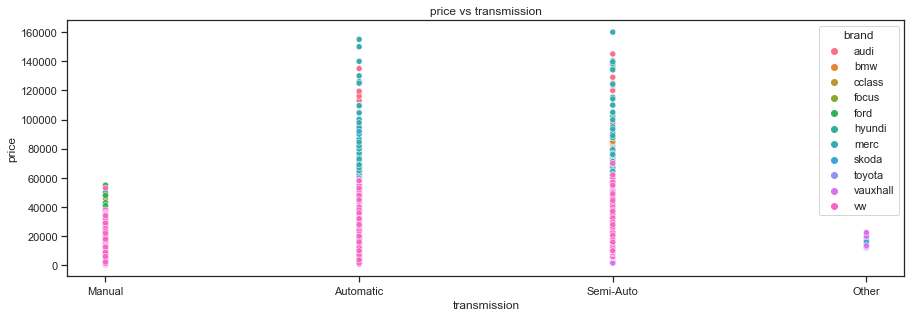

In [55]:
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
graph=sns.barplot(data=df, x='transmission', y='price', ci=None, palette='Set2')
for p in graph.patches:
    height = p.get_height()
    graph.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
                textcoords='offset points')
plt.ylim(0, 30000)    
plt.title('Perbandingan nilai Rata-Rata price berdasarkan transmission') 
plt.show()

sns.set_theme(style='ticks', palette='Set2')
plt.figure(figsize=(15,10))
plt.subplot(3,1,2)
sns.scatterplot(data=df, x='transmission', y='price', hue='fuelType')
plt.title('price vs transmission') 
plt.show()

plt.figure(figsize=(15,16))
plt.subplot(3,1,3)
sns.scatterplot(data=df, x='transmission', y='price', hue='brand')
plt.title('price vs transmission') 
plt.show()

**Kesimpulan Uji 6 :**

1. Jenis transmisi memiliki pengaruh terhadap penentuan harga jual mobil, dimana mobil dengan jenis transmisi _Semi-Auto_ memiliki rata-rata harga jual yg lebih tinggi dibanding mobil dengan jenis transmisi lainnya sedangkan mobil dengan jenis transmisi _Manual_ memiliki rata-rata harga jual yg paling rendah dibanding mobil dengan jenis transmisi lainnya.
2. Pada data ini, secara umum digambarkan tiap brand mobil memiliki sebaran jenis bahan bakar terhadap masing-masing tipe transmisi yang cukup merata.

### Uji 7 : _price_ vs _fuelType_

Hipotesis:

Ho: rata-rata harga mobil tiap jenis bahan bakar saling bernilai sama 

Ha: rata-rata harga mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [56]:
fuel=list(df['fuelType'].unique())

In [57]:
stats,pval = kruskal(*[df[df['fuelType'] == i]['price'] for i in fuel])

print('Nilai statistic:', stats)
print('Nilai p-value:', pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata harga mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata harga mobil tiap jenis bahan bakar saling bernilai sama.')

Nilai statistic: 8223.813365205857
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata harga mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Visualisasi :**

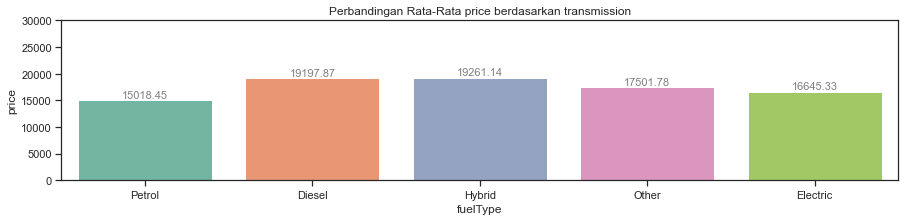

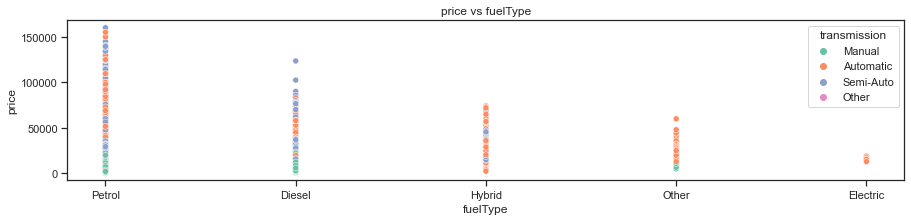

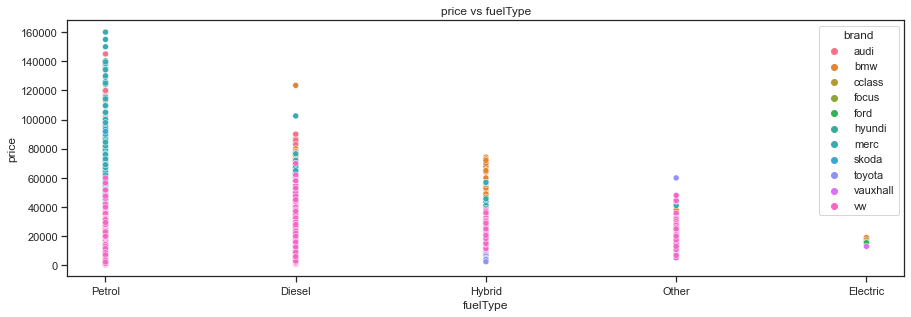

In [58]:
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
graph=sns.barplot(data=df, x='fuelType', y='price', ci=None, palette='Set2')
for p in graph.patches:
    height = p.get_height()
    graph.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
                textcoords='offset points')
plt.ylim(0, 30000)    
plt.title('Perbandingan Rata-Rata price berdasarkan transmission') 
plt.show()

sns.set_theme(style='ticks', palette='Set2')
plt.figure(figsize=(15,10))
plt.subplot(3,1,2)
sns.scatterplot(data=df, x='fuelType', y='price', hue='transmission')
plt.title('price vs fuelType') 
plt.show()

plt.figure(figsize=(15,16))
plt.subplot(3,1,3)
sns.scatterplot(data=df, x='fuelType', y='price', hue='brand')
plt.title('price vs fuelType') 
plt.show()

**Kesimpulan Uji 7 :**

Jenis transmisi memiliki pengaruh terhadap penentuan harga jual mobil, dimana mobil dengan tipe bahan bakar _Hybrid_ memiliki rata-rata harga jual yg lebih tinggi dibanding mobil dengan tipe bahan bakar lainnya sedangkan mobil dengan tipe bahan bakar _Petrol_ memiliki rata-rata harga jual yg paling rendah dibanding mobil dengan tipe bahan bakar lainnya.

### Uji 8 : _fuelType_ vs _mpg_

Hipotesis:

Ho: rata-rata nilai mpg mobil tiap jenis bahan bakar saling bernilai sama 

Ha: rata-rata nilai mpg mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [59]:
stats,pval = kruskal(*[df[df['fuelType'] == i]['mpg'].dropna() for i in fuel])

print('Nilai statistic:', stats)
print('Nilai p-value:', pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata nilai mpg mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata nilai mpg mobil tiap jenis bahan bakar saling bernilai sama.')

Nilai statistic: 15526.56871529918
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata nilai mpg mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Visualisasi :**

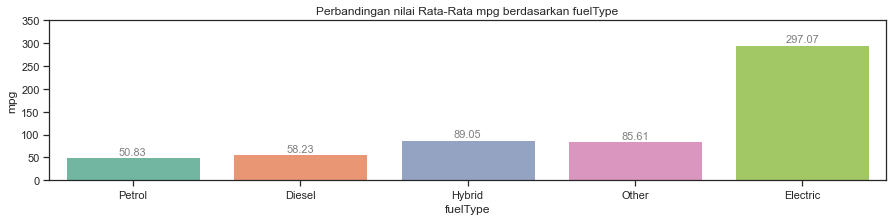

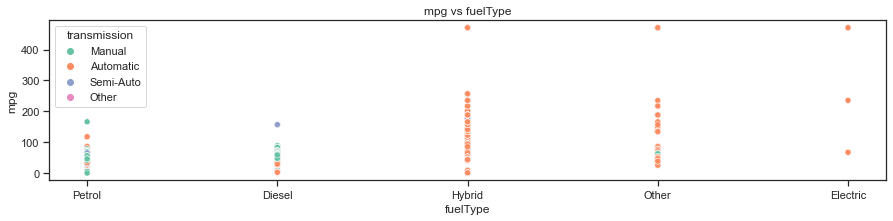

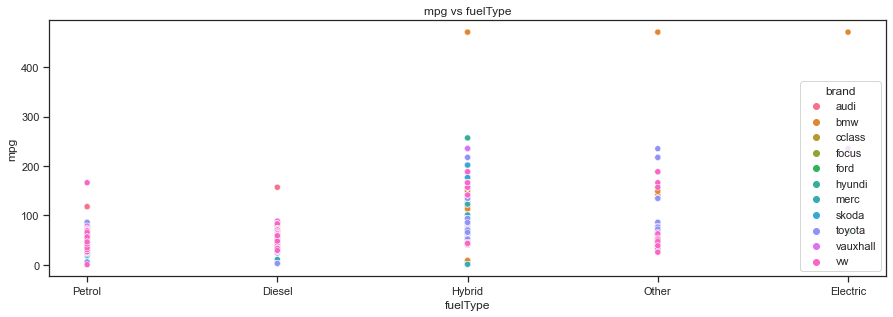

In [60]:
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
graph=sns.barplot(data=df, x='fuelType', y='mpg', ci=None, palette='Set2')
for p in graph.patches:
    height = p.get_height()
    graph.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
                textcoords='offset points')
plt.ylim(0, 350)    
plt.title('Perbandingan nilai Rata-Rata mpg berdasarkan fuelType') 
plt.show()

sns.set_theme(style='ticks', palette='Set2')
plt.figure(figsize=(15,10))
plt.subplot(3,1,2)
sns.scatterplot(data=df, x='fuelType', y='mpg', hue='transmission')
plt.title('mpg vs fuelType') 
plt.show()

plt.figure(figsize=(15,16))
plt.subplot(3,1,3)
sns.scatterplot(data=df, x='fuelType', y='mpg', hue='brand')
plt.title('mpg vs fuelType') 
plt.show()

**Kesimpulan Uji 8 :**

Jenis bahan bakar yg digunakan oleh suatu mobil memiliki pengaruh terhadap nilai _mpg_ nya, dimana mobil dengan _fuelType Electric_ memiliki nilai rata-rata _mpg_ yang jauh lebih tinggi dibanding mobil-mobil lainnya. Hal ini mungkin terjadi meskipun pada data ini mobil dengan _fuelType Electric_ hanya berjumlah 6 data.

### Uji 9 : _fuelType_ vs _tax_

Hipotesis:

Ho: rata-rata nilai tax mobil tiap jenis bahan bakar saling bernilai sama 

Ha: rata-rata nilai tax mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [61]:
stats,pval = kruskal(*[df[df['fuelType'] == i]['tax'].dropna() for i in fuel])

print('Nilai statistic:', stats)
print('Nilai p-value:', pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata nilai tax mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata nilai tax mobil tiap jenis bahan bakar saling bernilai sama.')

Nilai statistic: 5217.508336291944
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata nilai tax mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Visualisasi :**

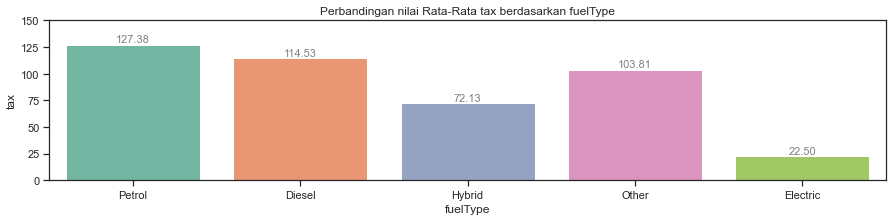

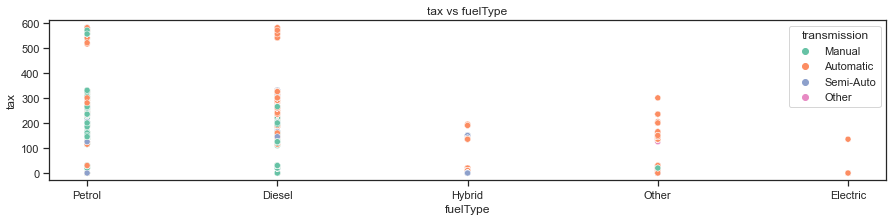

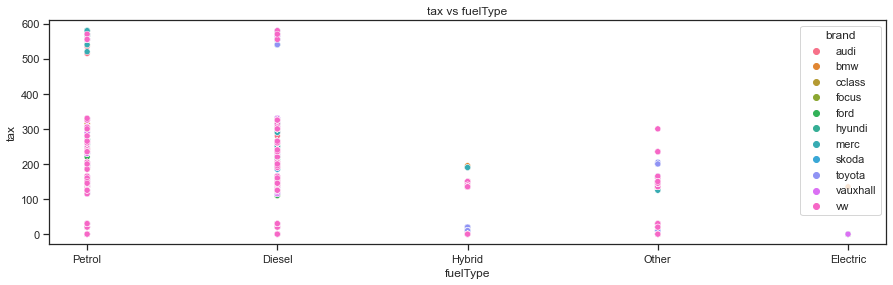

In [62]:
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
graph=sns.barplot(data=df, x='fuelType', y='tax', ci=None, palette='Set2')
for p in graph.patches:
    height = p.get_height()
    graph.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
                textcoords='offset points')
plt.ylim(0, 150)   
plt.title('Perbandingan nilai Rata-Rata tax berdasarkan fuelType') 
plt.show()

sns.set_theme(style='ticks', palette='Set2')
plt.figure(figsize=(15,10))
plt.subplot(3,1,2)
sns.scatterplot(data=df, x='fuelType', y='tax', hue='transmission')
plt.title('tax vs fuelType') 
plt.show()

plt.figure(figsize=(15,14))
plt.subplot(3,1,3)
sns.scatterplot(data=df, x='fuelType', y='tax', hue='brand')
plt.title('tax vs fuelType') 
plt.show()

**Kesimpulan Uji 9 :**

Jenis bahan bakar yg digunakan oleh suatu mobil memiliki pengaruh terhadap nilai pajaknya, dimana mobil dengan _fuelType Electric_ memiliki rata-rata nilai pajak yang lebih rendah dibandingkan mobil-mobil lainnya. Di sisi lain, mobil dengan _fuelType Petrol_ memiliki rata-rata nilai pajak yang lebih tinggi dibandingkan mobil-mobil lainnya.

### Uji 10 : _tax_ vs _mpg_

**Korelasi :**

In [63]:
round(df['tax'].corr(df['mpg'],method='spearman'),6)

-0.576143

**Analisa Korelasi :**

* Fitur _tax_ memiliki korelasi **moderate** serta **berbanding Terbalik** dengan fitur _mpg_, dimana nilai korelasinya adalah 0.576143 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _mpg_** dari mobil akan menyebabkan **nilai _tax_ semakin rendah**.

**Visualisasi :**

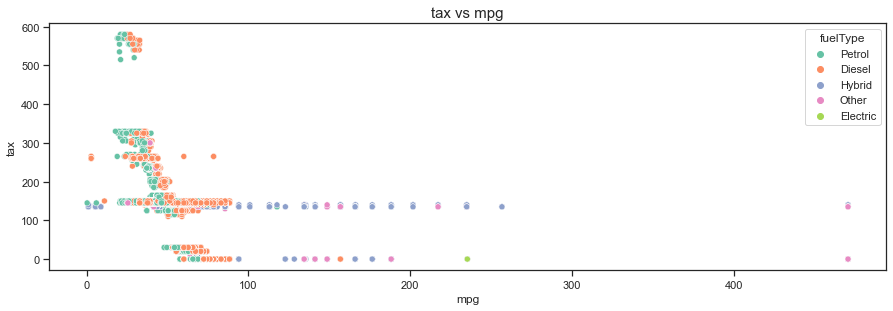

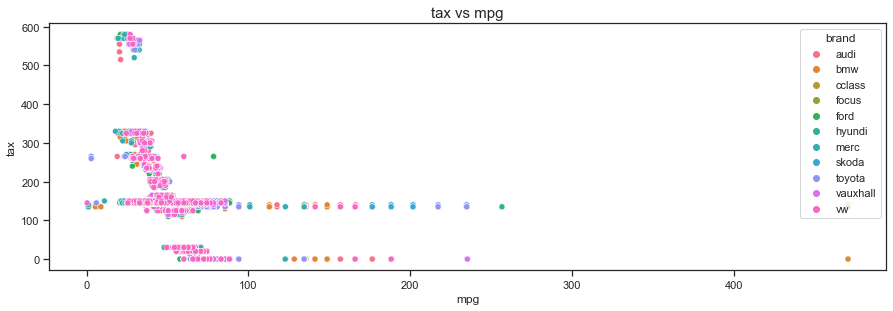

In [74]:
sns.set_theme(style='ticks', palette='Set2')
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.scatterplot(data=df, x='mpg', y='tax', hue='fuelType')
plt.title('tax vs mpg', size=15)
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.scatterplot(data=df, x='mpg', y='tax', hue='brand')
plt.title('tax vs mpg', size=15)
plt.show()

**Kesimpulan Uji 10 :**

* Nilai _mpg_ memiliki pengaruh terhadap nilai pajak mobil, dimana secara umum semakin tinggi nilai _mpg_ kendaraan maka nilai pajaknya akan cenderung semakin rendah.
* Mobil dengan _fuelType Hybrid_ memiliki rata-rata nilai _mpg_ yang tinggi serta nilai pajak yang relatif rendah.
* Terdapat mobil dengan nilai nilai _mpg_ yang relatif rendah dengan nilai pajak yang paling tinggi dibanding mobil-mobil lainnya, hal ini terjadi karena mobil-mobil ini termasuk pada mobil brand mewah.
* Terdapat mobil dengan nilai nilai _mpg_ yang relatif cukup tinggi dengan nilai pajak yang relatif paling rendah dibanding mobil-mobil lainnya, hal ini kemungkinan terjadi karena mobil-mobil ini merupakan mobil-mobil dengan tingkat emisi yang rendah.

### Uji 11 : _mileage_ vs _age_

**Korelasi :**

In [65]:
round(df['mileage'].corr(df['age'],method='spearman'),6)

0.813931

**Analisa Korelasi :**

* Fitur _mileage_ memiliki korelasi **strong** serta **berbanding Lurus** dengan fitur _age_, dimana nilai korelasinya adalah 0.813931 dengan arah positif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _age_** dari mobil akan menyebabkan **nilai _mileage_ semakin tinggi**.

**Visualisasi :**

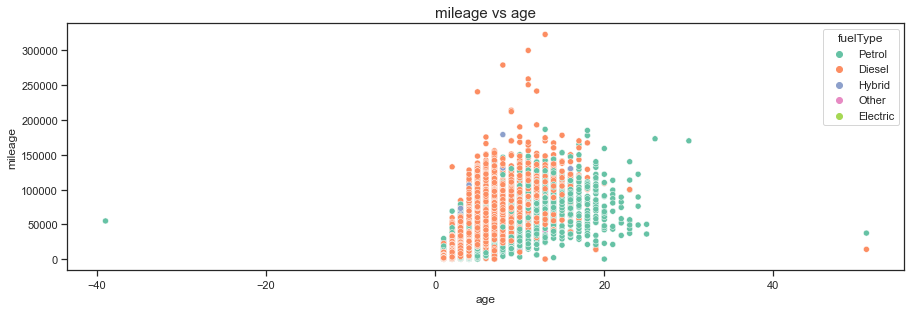

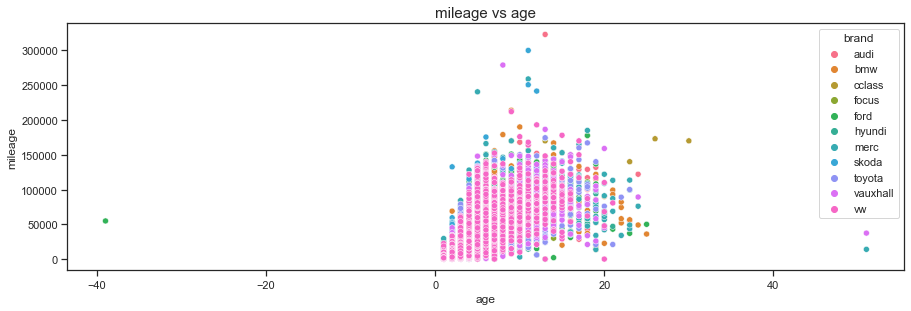

In [66]:
sns.set_theme(style='ticks', palette='Set2')
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.scatterplot(data=df, x='age', y='mileage', hue='fuelType')
plt.title('mileage vs age', size=15)
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.scatterplot(data=df, x='age', y='mileage', hue='brand')
plt.title('mileage vs age', size=15)
plt.show()

**Kesimpulan Uji 11 :**

* Umur dari mobil memiliki pengaruh terhadap total jarak yg telah ditempuh, dimana secara umum mobil yg memiliki umur lebih tinggi cenderung memiliki total jarak yg telah ditempuh lebih tinggi dibandingkan mobil dengan umur yg lebih rendah.
* Mobil dengan nilai umur yang lebih tinggi lebih banyak terdapat pada mobil dengan jenis bahan bakar _Petrol_.
* Mobil dengan nilai total jarak yg telah ditempuh yang paling tinggi terdapat pada mobil dengan jenis bahan bakar _Diesel_.

### Uji 12 : _age_ vs _tax_

**Korelasi :**

In [67]:
round(df['age'].corr(df['tax'],method='spearman'),6)

-0.32987

**Analisa Korelasi :**

* Fitur _tax_ memiliki korelasi **moderate** serta **berbanding Terbalik** dengan fitur _age_, dimana nilai korelasinya adalah 0.32987 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _age_** dari mobil akan menyebabkan **nilai _tax_ semakin rendah**.

**Visualisasi :**

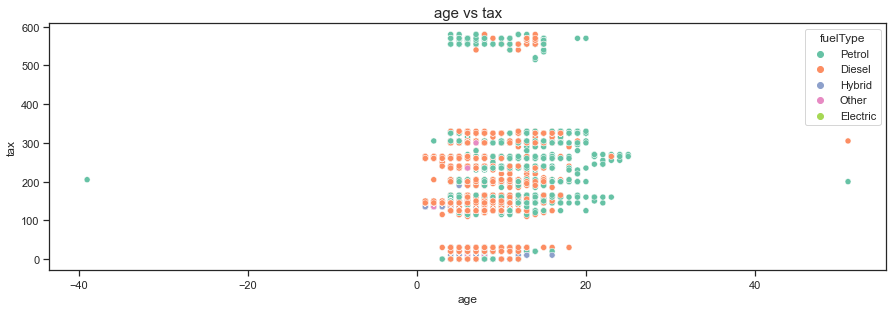

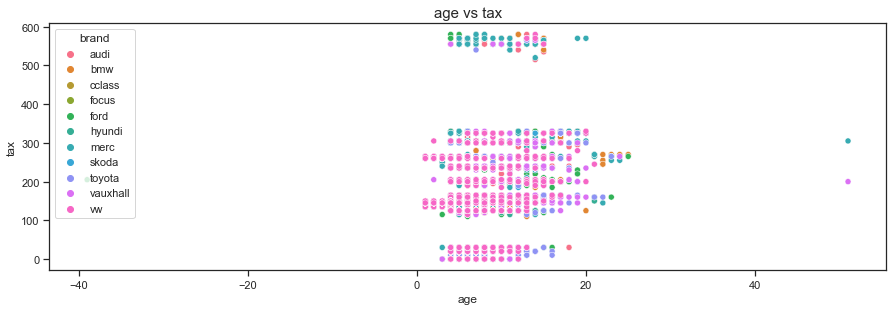

In [80]:
sns.set_theme(style='ticks', palette='Set2')
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.scatterplot(data=df, x='age', y='tax', hue='fuelType')
plt.title('age vs tax', size=15)
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.scatterplot(data=df, x='age', y='tax', hue='brand')
plt.title('age vs tax', size=15)
plt.show()

**Kesimpulan Uji 12 :**

Berdasarkan grafik, sebaran data tiap mobil berdasarkan umurnya memiliki sebaran nilai pajak yang cukup merata. Dapat dikatakan nilai umur dari mobil memiliki pengaruh yang sedikit bahkan hampir tidak memiliki pengaruh terhadap nilai pajak mobil.


**Save data df to be used on file 02 Preprocessing - Final Preparation**

In [69]:
%store df

Stored 'df' (DataFrame)


In [70]:
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi,4
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi,5
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi,5
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi,4
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi,2
...,...,...,...,...,...,...,...,...,...,...,...
108535,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,vw,9
108536,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,vw,13
108537,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,vw,12
108538,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,vw,15
